In [221]:
import os, sys
import numpy as np
import pandas as pd

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import corner

from lenstronomy.Cosmo.lcdm import LCDM
# Sampling from the BNN posterior
from h0rton.configs import TrainValConfig, TestConfig
import h0rton.losses
from h0rton.h0_inference import *
import h0rton.tdlmc_data
import h0rton.tdlmc_utils
import h0rton.train_utils as train_utils
import h0rton.models
from h0rton.trainval_data import XYData
from torch.utils.data import DataLoader
from baobab.data_augmentation.noise_lenstronomy import NoiseModelNumpy
from baobab.configs import BaobabConfig
from baobab.sim_utils import metadata_utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

#plt.rcParams['text.latex.preamble'] = [r'\boldmath']

In [15]:
true_H0 = 70.0
true_Om0 = 0.3
cfg = TrainValConfig.from_file(os.path.join('..', 'experiments', 'v11', 'train_val_cfg.json'))
test_cfg = TestConfig.from_file('/home/jwp/stage/sl/h0rton/experiments/v11/mcmc_default_chain_test.json')
#train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)


In [16]:
val_baobab_cfg = BaobabConfig.from_file(cfg.data.train_baobab_cfg_path)

val_truth = pd.read_csv(os.path.join(val_baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=5000)
val_truth['src_light_center_x_offset'] = val_truth['src_light_center_x'] - val_truth['lens_mass_center_x']
val_truth['src_light_center_y_offset'] = val_truth['src_light_center_y'] - val_truth['lens_mass_center_y']
val_truth = metadata_utils.add_qphi_columns(val_truth)
val_truth = metadata_utils.add_g1g2_columns(val_truth)

In [17]:
val_truth['D_dt'] = 0.0
for i in range(val_truth.shape[0]):
    row_val = val_truth.iloc[i]
    lcdm = LCDM(z_lens=row_val['z_lens'], z_source=row_val['z_src'], flat=True)
    row_D_dt = lcdm.D_dt(H_0=true_H0, Om0=true_Om0)
    val_truth.loc[i, 'D_dt'] = row_D_dt

In [297]:
lens_i = 63

version_id = 11
version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
default_samples_path = os.path.join(version_dir, 'mcmc_default_chain_test', 'mcmc_samples_{0:04d}.csv'.format(lens_i))
#hybrid_samples_path = os.path.join(version_dir, 'hybrid_120', 'mcmc_samples_{0:04d}.csv'.format(lens_i))



#default_mc_samples = pd.DataFrame(bnn_samples[lens_i, :, :], columns=cfg.data.Y_cols) 
default_samples = pd.read_csv(default_samples_path, index_col=None)
#hybrid_samples = pd.read_csv(hybrid_samples_path, index_col=None)

fm_samples_path = os.path.join(version_dir, 'forward_modeling_{:d}'.format(lens_i), 'mcmc_samples_{0:04d}.csv'.format(lens_i))
fm_samples = pd.read_csv(fm_samples_path, index_col=None)

#fm_samples = fm_samples[np.isfinite(fm_samples)]
num_fm_samples = fm_samples.shape[0]
print(num_fm_samples)
fm_samples = fm_samples.iloc[int(fm_samples.shape[0]*0.9):]
print(fm_samples.shape[0])
#default_samples = metadata_utils.add_g1g2_columns(default_samples)
#default_mc_samples = metadata_utils.add_qphi_columns(default_mc_samples)
#default_mc_samples = metadata_utils.add_gamma_psi_ext_columns(default_mc_samples)
#hybrid_samples = metadata_utils.add_g1g2_columns(hybrid_samples)

#default_mc_samples['src_light_center_x_offset'] = default_mc_samples['src_light_center_x']
#default_mc_samples['src_light_center_y_offset'] = default_mc_samples['src_light_center_y']
# Redefine source center as the absolute position
default_samples['src_light_center_x_offset'] = default_samples['src_light_center_x']
default_samples['src_light_center_y_offset'] = default_samples['src_light_center_y']
default_samples['src_light_center_x'] = default_samples['src_light_center_x'] + default_samples['lens_mass_center_x']
default_samples['src_light_center_y'] = default_samples['src_light_center_y'] + default_samples['lens_mass_center_y']

fm_samples['src_light_center_x_offset'] = fm_samples['src_light_center_x']
fm_samples['src_light_center_y_offset'] = fm_samples['src_light_center_y']
fm_samples['src_light_center_x'] = fm_samples['src_light_center_x'] + fm_samples['lens_mass_center_x']
fm_samples['src_light_center_y'] = fm_samples['src_light_center_y'] + fm_samples['lens_mass_center_y']

#fm_samples = fm_samples.iloc[int(num_fm_samples*0.7):]

test_baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)

truth = pd.read_csv(os.path.join(test_baobab_cfg.out_dir, 'metadata.csv'), index_col=None)
truth['src_light_center_x_offset'] = truth['src_light_center_x'] - truth['lens_mass_center_x']
truth['src_light_center_y_offset'] = truth['src_light_center_y'] - truth['lens_mass_center_y']
truth = metadata_utils.add_qphi_columns(truth)
truth = metadata_utils.add_g1g2_columns(truth)
truth_lens_i = truth.iloc[lens_i]
#print(truth_lens_i)



lcdm = LCDM(z_lens=truth_lens_i['z_lens'], z_source=truth_lens_i['z_src'], flat=True)
true_D_dt = lcdm.D_dt(H_0=true_H0, Om0=true_Om0)
truth_lens_i['D_dt'] = true_D_dt

default_samples['D_dt'] *= np.random.normal(1, 0.025, default_samples['D_dt'].values.shape)
fm_samples['D_dt'] *= np.random.normal(1, 0.025, fm_samples['D_dt'].values.shape)

275000
27500


/home/jwp/miniconda3/envs/baobab/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [298]:
print(truth_lens_i['z_lens'], truth_lens_i['z_src'])

#fm_samples.describe()

#plt.close('all')
#plt.hist(fm_samples['lens_mass_theta_E'].iloc[10000:])
#plt.show()
#np.sum(np.isfinite(fm_samples))

0.8953183031978688 1.4128528410576917


In [299]:
total_cols = [
 'lens_mass_gamma',
 'lens_mass_theta_E',
 'lens_mass_e1',
 'lens_mass_e2',
 'external_shear_gamma1',
 'external_shear_gamma2',
'src_light_R_sersic',
    'src_light_center_x',
    'src_light_center_y',
'D_dt'
]

cols_to_plot = [
 'lens_mass_gamma',
 'lens_mass_theta_E',
 'lens_mass_e1',
 'lens_mass_e2',
 'external_shear_gamma1',
 'external_shear_gamma2',
'src_light_R_sersic',
    'src_light_center_x',
    'src_light_center_y',
'D_dt'
]
#cols_to_plot = cfg.data.Y_cols
labels = [
 r'$\gamma_{\rm lens}$',
 r'${\theta}_E (^{\prime \prime})$',
 '$e_1$',
 '$e_2$',
 '$\gamma_1$',
 '$\gamma_2$',
r'$R_{\rm src} (^{\prime \prime})$',
    r"$x_{\rm src} ('')$",
    r"$y_{\rm src} ('')$",
r'$D_{\Delta t}$ (Mpc)'
]

offset = np.array([0.3, #0.05, 
                   0.1, 
                   0.2, 
                   0.2, 
                   0.1, 
                   0.1, 
                   0.2, 
                   0.1,
                   0.1,
                   2000])*2.0

offset_dict = dict(zip(total_cols, offset))
middle = truth_lens_i[cols_to_plot].values
offset_to_plot = [offset_dict[c] for c in cols_to_plot]
display_range = list(zip(middle - offset_to_plot, middle + offset_to_plot))
display_range[-1] = (max(0, display_range[-1][0]), display_range[-1][1])
print(display_range[-1])
labels_dict = dict(zip(total_cols, labels))

(7028.089471678284, 15028.089471678284)


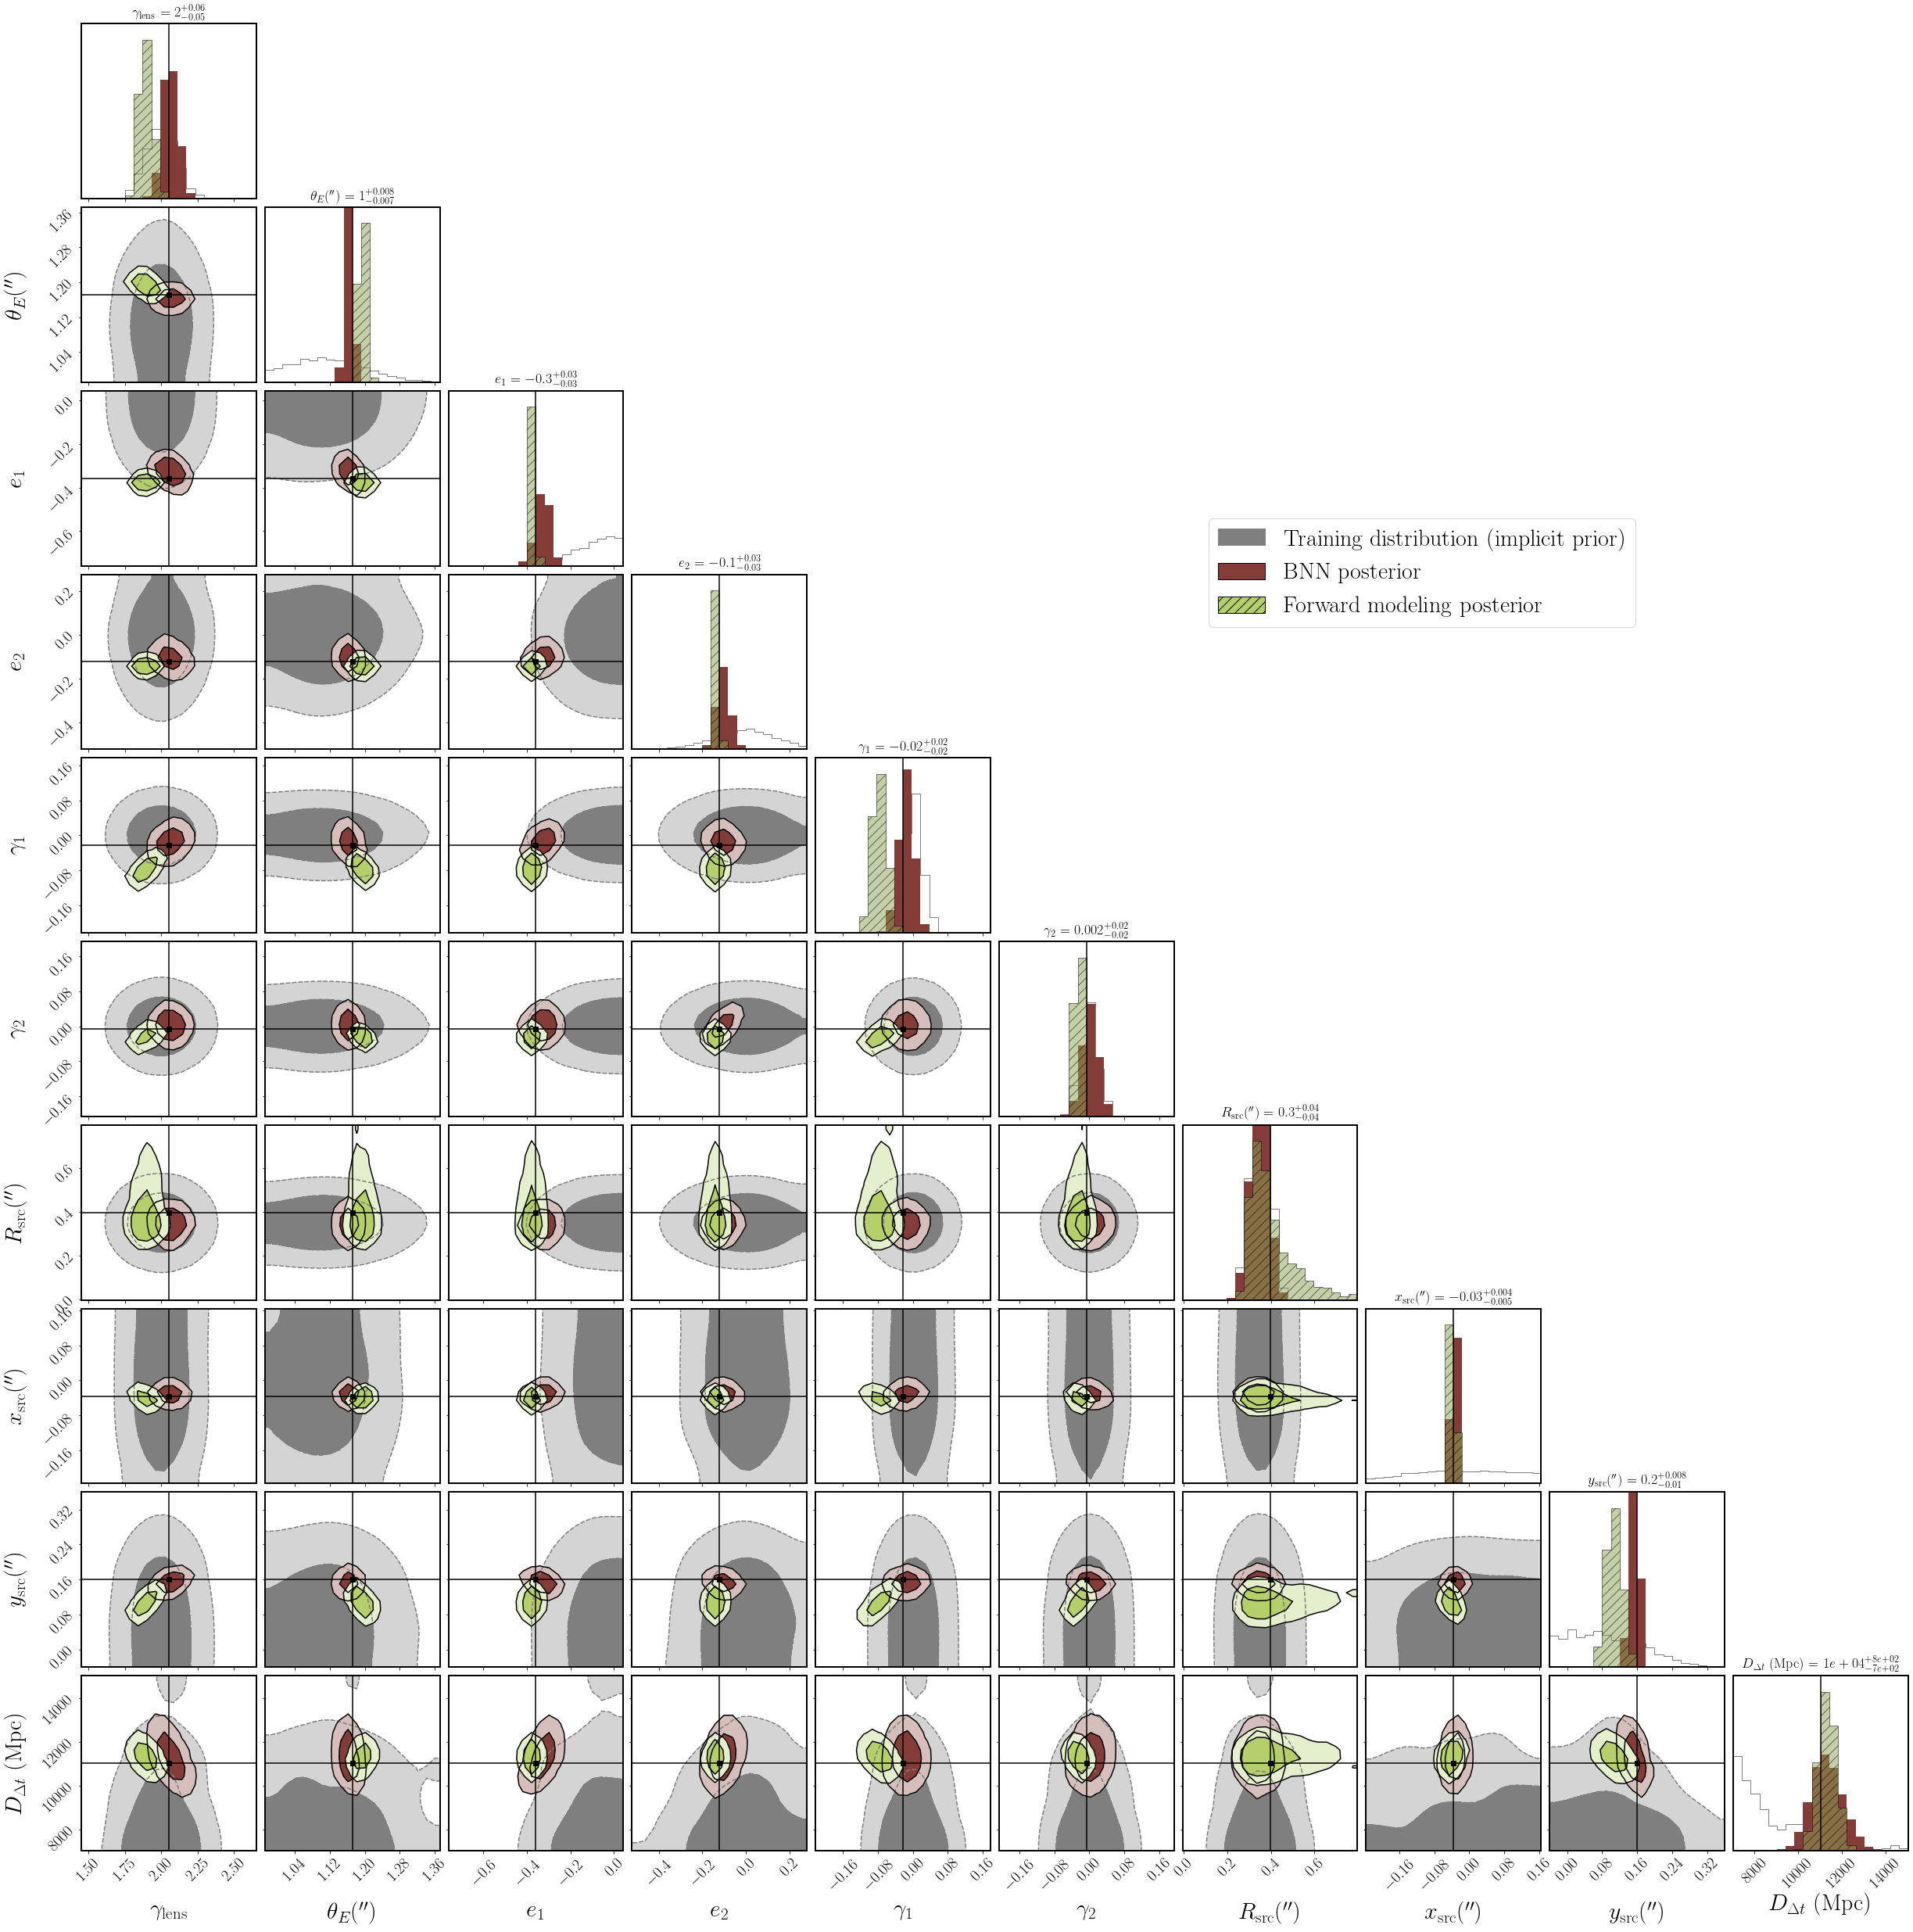

In [304]:
plt.close('all')

bnn_post_fig = corner.corner(val_truth[cols_to_plot],
             color='tab:gray',
             smooth=2.0,
             alpha=0.1,
             fill_contours=True,
             plot_datapoints=False,
                  labels=[labels_dict[c] for c in cols_to_plot],
                  label_kwargs={'fontsize': 30},
                  
             plot_contours=True,
             show_titles=False,
                  plot_density=False,
             levels=[0.68, 0.95],
             contour_kwargs=dict(linestyles='--'),
                  #contourf_kwargs=dict(colors='tab:gray'),
             quiet=True,
             #fig=bnn_post_fig,
             range=display_range,
             #range=[0.99]*len(cols_to_plot),
             use_math_text=True,
             hist_kwargs=dict(density=True,),
                 hist2d_kwargs=dict(pcolor_kwargs=dict(alpha=0.1)))

# BNN
_ = corner.corner(default_samples[cols_to_plot],
                             color='#843c39',
                             smooth=0.6,
                             alpha=1.0,
                             labels=[labels_dict[c] for c in cols_to_plot],
                             label_kwargs={'fontsize': 30},
                             fill_contours=True,
                             plot_datapoints=False,
                             plot_contours=True,
                             show_titles=True,
                             levels=[0.68, 0.95],
                             truths=truth_lens_i[cols_to_plot],
                              truth_color='k',
                             contour_kwargs=dict(linestyles='solid', colors='k'),
                  #contourf_kwargs=dict(colors='#843c39'),
                             quiet=True,
                             #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                             title_fmt=".1g",
                             fig=bnn_post_fig,
                             title_kwargs={'fontsize': 18},
                             range=display_range,
                             #range=[0.99]*len(cols_to_plot),
                             use_math_text=True,
                             hist_kwargs=dict(density=True, histtype='stepfilled'))

# Forward modeling
_ = corner.corner(fm_samples[cols_to_plot],
                     color='#b5cf6b',
             smooth=0.6,
             alpha=1.0,
                  fig=bnn_post_fig,
             fill_contours=True,
             plot_datapoints=False,
                  labels=[labels_dict[c] for c in cols_to_plot],
                  label_kwargs={'fontsize': 30},
                             plot_density=False,
             plot_contours=True,
             show_titles=False,
             levels=[0.68, 0.95],
             contour_kwargs=dict(linestyles='solid', colors='k'),
             #contourf_kwargs=dict(colors='#b5cf6b'),
             quiet=True,
             #fig=bnn_post_fig,
             range=display_range,
             #range=[0.99]*len(cols_to_plot),
             use_math_text=True,
             hist_kwargs=dict(density=True, histtype='stepfilled', alpha=0.5, color=cm.tab20b(0.26315789), hatch='//', edgecolor='k'),
             hist2d_kwargs=dict(hatch='//'))

bnn_post_fig.subplots_adjust(right=1.5, top=1.5)

legend_elements = [
                  
    Patch(facecolor='tab:gray', edgecolor='tab:gray', label=r'Training distribution (implicit prior)'),
    Patch(facecolor='#843c39', edgecolor='k', alpha=1.0, label=r'BNN posterior'),
    Patch(facecolor='#b5cf6b', edgecolor='k', alpha=1.0, hatch='//', label=r'Forward modeling posterior'),
    #Line2D([0], [0], color=cmap(standard_normal_p[2] + 0.5), lw=1, alpha=1, label=r'100\% of lenses have truth within 99.7\% C.I.'),
     #Line2D([0], [0], color=cmap(standard_normal_p[1] + 0.5), lw=1, alpha=1, label=r'94.5\% of lenses have truth within 95.5\% C.I.'),
    #Line2D([0], [0], color=cmap(standard_normal_p[0] + 0.5), lw=1, alpha=1, label=r'64.5\% of lenses have truth within 68.3\% C.I.'),
               ]
plt.legend(handles=legend_elements, fontsize=30, loc=[-3., 7])
for ax in bnn_post_fig.get_axes():
    ax.tick_params(axis='both', labelsize=20)

plt.show()
#plt.savefig('../example_cornerplot_no_image_{:d}.png'.format(lens_i))


In [264]:
bnn_post_fig.savefig('../example_cornerplot_no_image_{:d}.png'.format(lens_i), dpi=300, pad_inches=0.3, bbox_inches='tight')

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


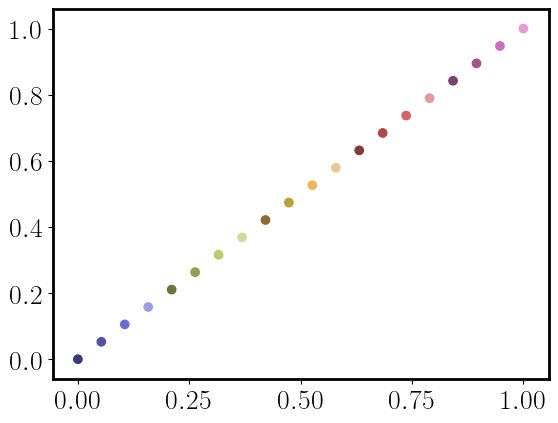

In [161]:
import matplotlib.cm as cm

plt.close('all')
color_interp = np.linspace(0, 1.0, 20)
print(color_interp)
plt.scatter(color_interp, color_interp, color=cm.tab20b(color_interp))
plt.show()

In [162]:
colors.rgb2hex(tab_cmap(0.31578947))

'#b5cf6b'

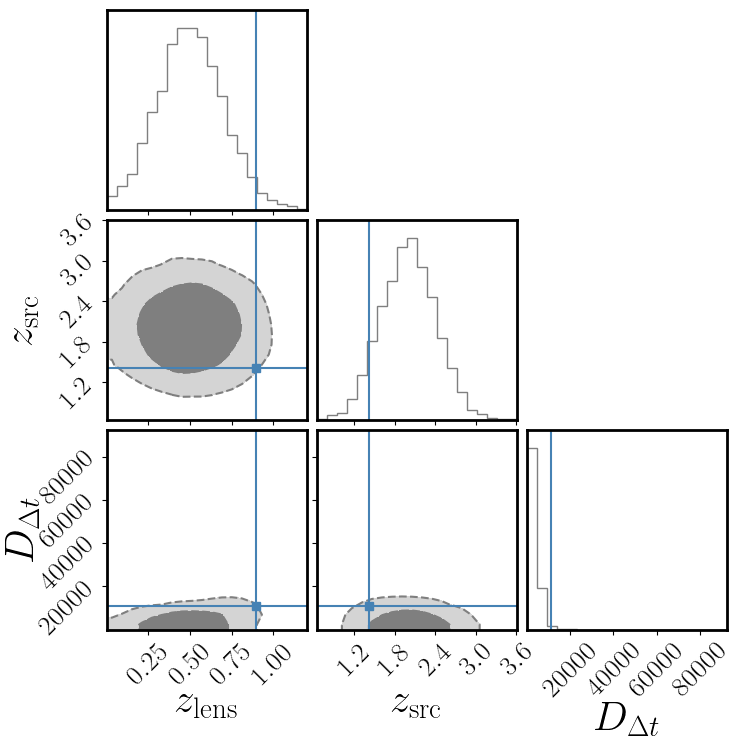

In [149]:
plt.close('all')




redshifts = corner.corner(val_truth[['z_lens', 'z_src', 'D_dt']],
             color='tab:gray',
             smooth=1.0,
             alpha=0.1,
             fill_contours=True,
             plot_datapoints=False,
                  labels=[r'$$z_{\rm lens}$$', r'$$z_{\rm src}$$', r'$$D_{\Delta t}$$'],
                  label_kwargs={'fontsize': 30},
                  truths=truth_lens_i[['z_lens', 'z_src', 'D_dt']],
             plot_contours=True,
             show_titles=False,
                  plot_density=False,
             levels=[0.68, 0.95],
             contour_kwargs=dict(linestyles='--'),
                  #contourf_kwargs=dict(colors='tab:gray'),
             quiet=True,
             #fig=bnn_post_fig,
             #range=display_range,
             #range=[0.99]*len(cols_to_plot),
             use_math_text=True,
             hist_kwargs=dict(density=True),
                 hist2d_kwargs=dict(pcolor_kwargs=dict(alpha=0.1)))

plt.show()

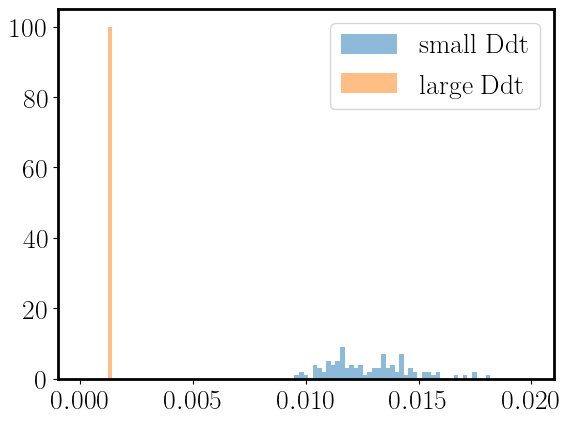

In [158]:
plt.close('all')
binning = np.linspace(0, 0.02, 100)
_ = plt.hist(100/(np.random.randn(100)*10 + 80), label='small Ddt', alpha=0.5, bins=binning)
_ = plt.hist(100/(np.random.randn(100)*10 + 800), label='large Ddt', bins=binning, alpha=0.5)
plt.legend()
plt.show()

In [156]:
1/80, 1/800

(0.0125, 0.00125)

In [95]:
plt.savefig('../example_cornerplot_no_image_{:d}.png'.format(lens_i))

In [198]:
from scipy.stats import chi2


In [199]:
for df_i in [48, 89, 200]:
    print(chi2.ppf([0.99, 0.01], df=df_i)/df_i)

[1.53505497 0.58702102]
[1.38137311 0.68458487]
[1.24722561 0.78215983]
